In [1]:
import torch 
import torchvision
from torch import  nn
from d2l import torch as d2l

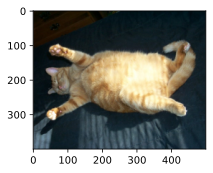

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale = 1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

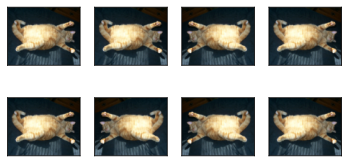

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

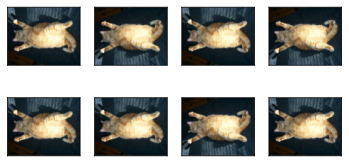

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

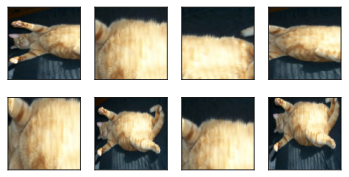

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200),
                                                      scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

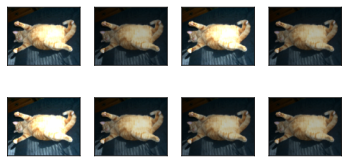

In [7]:
# 改变颜色
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,saturation=0, hue=0))

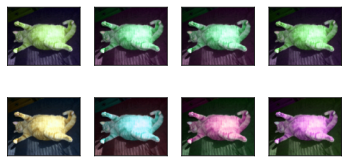

In [8]:
apply(img, torchvision.transforms.ColorJitter(brightness=0,contrast=0, saturation=0, hue=0.5))

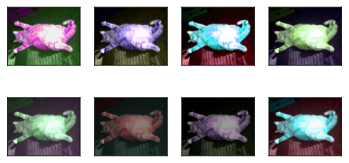

In [9]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5))

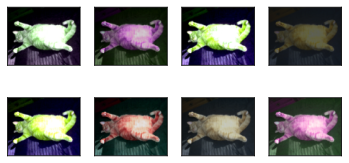

In [10]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)

apply(img, color_aug)

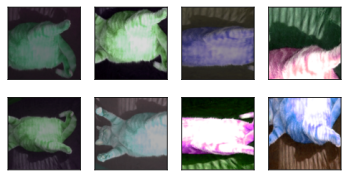

In [11]:
# 多种方法结合

augs = torchvision.transforms.Compose([torchvision.transforms.RandomVerticalFlip(), color_aug, shape_aug])


apply(img, augs)

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

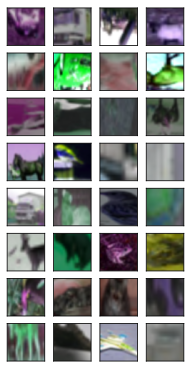

In [12]:
#all_images = torchvision.datasets.CIFAR10(root='../data',train=True, download=True,transform=augs)
all_images = torchvision.datasets.CIFAR10(root='/public/torchvision_datasets/',train=True, download=False)

d2l.show_images([all_images[i][0] for i in range(32)], num_cols=8, num_rows=4, scale=0.8)

In [15]:
train_augs = torchvision.transforms.Compose([
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()])

In [16]:
def load_cifar10(is_train, augs, batch_size):
    dataset    = torchvision.datasets.CIFAR10(root='../data', train=is_train, 
                                    transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, 
                                    shuffle=is_train, num_workers=d2l.get_dataloader_workers()) # 4线程载入
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    # bert 微调需要的
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()

    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                                devices = d2l.try_all_gpus()):
    timer , num_batchs = d2l.Timer(), len(train_iter)
    animator = d2l.Animator('epoch', xlim=[1, num_epochs],  legend=['train_loss', 'train_acc', 'test_acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i ,( X, y) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, X, y, loss, trainer, devices)
            metric.add(l, acc, y.shape[0],  y.numel())
            timer.stop()
            if (i+1) % (num_batchs // 5) == 0  or i == num_batchs -1:
                animator.add( epoch + (i+1) / num_batchs, (metric[0] / metric[2], metric[1] / metric[3], None) )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss  {metric[0] / metric[2]:.3f}, train  acc,'
                            f'  {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum() :.1f} examples / sec on' 
          f'{str(devices)}')



In [20]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) == (nn.Linear, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(is_train=True, augs=train_augs, batch_size=batch_size)
    test_iter = load_cifar10(is_train=False, augs=test_augs, batch_size=batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(),  lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
# 坑：d2l 中   resnet 使用 lazy 生成，需要进行一次 推理 确定模型参数
x = torch.rand(1,3,28,28).to(devices[0])
net = net.to(devices[0])
net(x)

In [ ]:

train_with_data_aug(train_augs,test_augs, net )